In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import CIFAR10 dataset
# The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. 
# The dataset is divided into 50,000 training images and 10,000 testing image

# The classes are:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# You can access the CIFAR10 directly from TensorFlow
cifar10 = tf.keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [3]:
# Explore the data. The images are 32x32 numpy arrays, with pixel range from 0 to 255. 
# The last dimension is related to color channels, refers to (R,G,B).

print(train_images.shape)

(50000, 32, 32, 3)


In [4]:
# The labels are an array of integers, ranging from 0 to 9.
df = pd.DataFrame(class_names,columns=['Class'])
print(df)

        Class
0    airplane
1  automobile
2        bird
3         cat
4        deer
5         dog
6        frog
7       horse
8        ship
9       truck


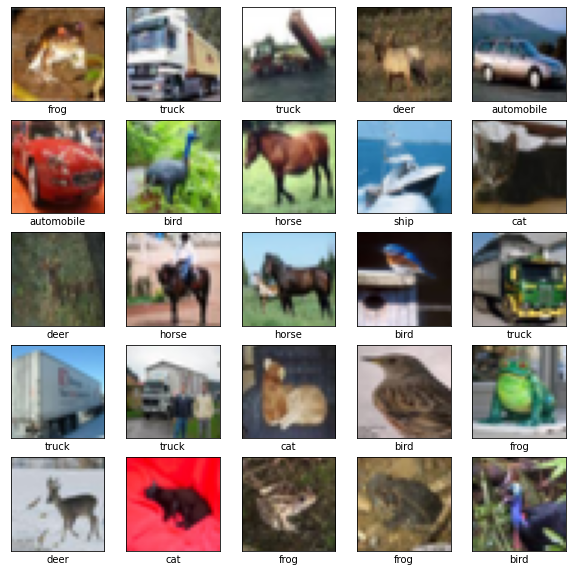

In [5]:
# First, we can visualize the CIFAR10 data
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()


In [6]:
# Now we create a cat_vs_dog dataset from Cifar10
class_names = ['cat', 'dog']

# Get from CIFAR10 the indexes for cats and dogs
idx_cats = np.argwhere(train_labels[:,0] == 3)
idx_dogs = np.argwhere(train_labels[:,0] == 5)

# Create the new dataset and change the labels: 1 for dogs and 0 for cats
# If you have kernel problems, reduce the training size
train_size = 5000

train_images_cats_dogs = np.zeros((train_size,32,32,3), dtype='uint8')
train_labels_cats_dogs = np.zeros((train_size,1))

train_images_cats_dogs[:train_size//2] = train_images[idx_cats[:train_size//2,0]]
train_images_cats_dogs[train_size//2:train_size] = train_images[idx_dogs[:train_size//2,0]]

train_labels_cats_dogs[:train_size//2] = tf.zeros_like(idx_cats[:train_size//2])
train_labels_cats_dogs[train_size//2:train_size] = tf.ones_like(idx_cats[:train_size//2])

train_images_cats_dogs = tf.convert_to_tensor(train_images_cats_dogs)

# Shuffle the train data before train
indices = tf.range(start=0, limit=tf.shape(train_images_cats_dogs)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

train_images_cats_dogs = tf.gather(train_images_cats_dogs, shuffled_indices)
train_labels_cats_dogs = tf.gather(train_labels_cats_dogs, shuffled_indices)


2022-05-02 10:46:58.622044: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-02 10:46:58.622978: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


In [7]:
# We do the same for test dataset
idt_cats = np.argwhere(test_labels[:,0] == 3)
idt_dogs = np.argwhere(test_labels[:,0] == 5)

# If you have kernel problems, reduce the test size
test_size = 1000

test_images_cats_dogs = np.zeros((test_size,32,32,3), dtype='uint8')
test_labels_cats_dogs = np.zeros((test_size,1))

test_images_cats_dogs[:test_size//2] = test_images[idt_cats[:test_size//2,0]]
test_images_cats_dogs[test_size//2:test_size] = test_images[idt_dogs[:test_size//2,0]]

test_labels_cats_dogs[:test_size//2] = tf.zeros_like(idt_cats[:test_size//2])
test_labels_cats_dogs[test_size//2:test_size] = tf.ones_like(idt_cats[:test_size//2])

test_images_cats_dogs = tf.convert_to_tensor(test_images_cats_dogs)

# Shuffle the test data
indices = tf.range(start=0, limit=tf.shape(test_images_cats_dogs)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

test_images_cats_dogs = tf.gather(test_images_cats_dogs, shuffled_indices)
test_labels_cats_dogs = tf.gather(test_labels_cats_dogs, shuffled_indices)

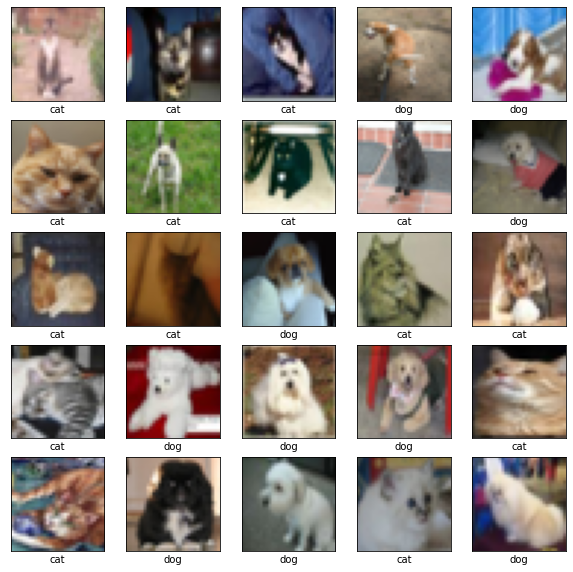

In [8]:
# Plot some pictures
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_cats_dogs[i])
    plt.xlabel(class_names[train_labels_cats_dogs[i][0]])
plt.show()

In [9]:
# Preprocess the data: Normalize pixel values to be between 0 and 1
train_images_cats_dogs = train_images_cats_dogs / 255
test_images_cats_dogs = test_images_cats_dogs / 255

In [10]:
# Build the models using keras layers 
# (The basic building block of a neural network is the layer. 
# Layers extract representations from the data fed into them.)

# Fully-connected neural network
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

# Documentation: https://www.tensorflow.org/guide/keras/sequential_model


In [11]:
# Overview of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 393,602
Trainable params: 393,602
Non-trainable params: 0
_________________________________________________________________


# Categorial-Cross entropy loss

It is the default loss function to use for multi-class classification problems where each class is assigned a unique integer value from 0 to (num_classes – 1). Computes the cross-entropy loss between true labels and predicted labels.

$Loss=-\sum_{i=1}^{N} y_i \cdot log \hat{y}_i$



## Compile the model
Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

+ Loss function - This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.

+ Optimizer - This is how the model is updated based on the data it sees and its loss function.

+ Metrics - Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [12]:
# Documentation: https://www.tensorflow.org/guide/keras/train_and_evaluate/

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Train the model


Training the neural network model requires the following steps:

+ Feed the training data to the model. 
+ The model learns to associate images and labels.
+ You ask the model to make predictions about a test set—in this example.
+ Verify that the predictions match the labels from the test labels.


In [13]:
history = model.fit(train_images_cats_dogs, train_labels_cats_dogs, 
                    epochs=20, 
                    validation_data=(test_images_cats_dogs, test_labels_cats_dogs))

Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 1s 297us/sample - loss: 0.7518 - accuracy: 0.5480 - val_loss: 0.7470 - val_accuracy: 0.5230
Epoch 2/20
5000/5000 [==============================] - 1s 126us/sample - loss: 0.6844 - accuracy: 0.5692 - val_loss: 0.7726 - val_accuracy: 0.5120
Epoch 3/20
5000/5000 [==============================] - 1s 126us/sample - loss: 0.6753 - accuracy: 0.5864 - val_loss: 0.6758 - val_accuracy: 0.5880
Epoch 4/20
5000/5000 [==============================] - 1s 133us/sample - loss: 0.6650 - accuracy: 0.5934 - val_loss: 0.6757 - val_accuracy: 0.5830
Epoch 5/20
5000/5000 [==============================] - 1s 127us/sample - loss: 0.6782 - accuracy: 0.5854 - val_loss: 0.6818 - val_accuracy: 0.5570
Epoch 6/20
5000/5000 [==============================] - 1s 127us/sample - loss: 0.6688 - accuracy: 0.5870 - val_loss: 0.6793 - val_accuracy: 0.5770
Epoch 7/20
5000/5000 [==============================] - 1s 127us

1000/1 - 0s - loss: 0.7744 - accuracy: 0.5800
test loss: 0.6937972302436829
test accuracy: 0.58


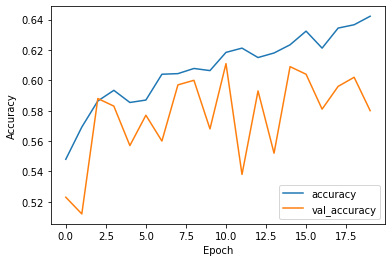

In [14]:
# Evaluate the model

plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images_cats_dogs,  test_labels_cats_dogs, verbose=2)

print('test loss:', test_loss)
print('test accuracy:', test_acc)


## Make Predictions
With the model trained, you can use it to make predictions about some images. 

In [15]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images_cats_dogs)

def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i][0], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i][0]
  plt.grid(False)
  plt.xticks(range(len(class_names)))
  plt.yticks([])
  thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

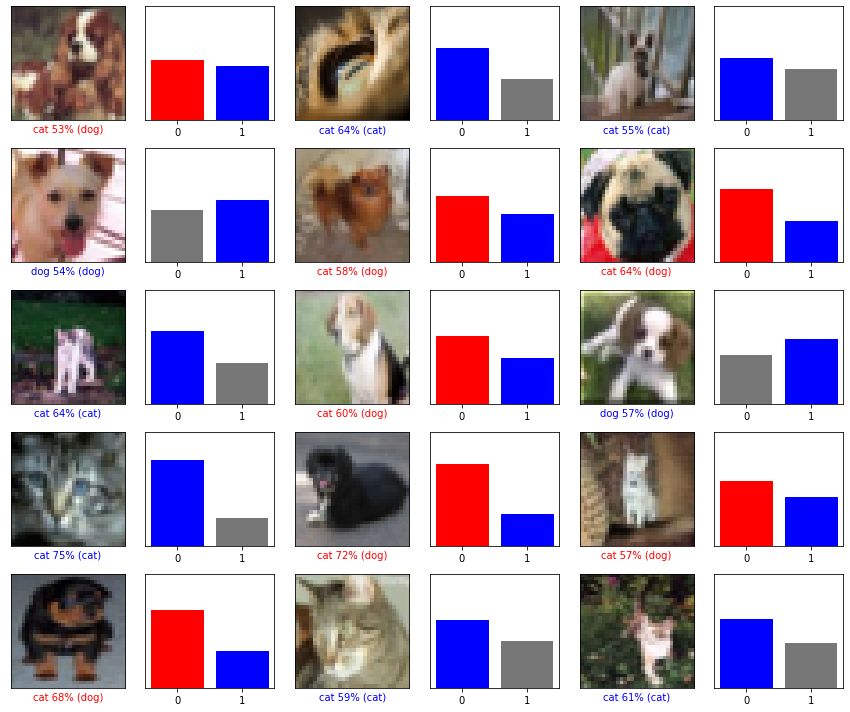

In [16]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels_cats_dogs, test_images_cats_dogs)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels_cats_dogs)
plt.tight_layout()
plt.show()

## To do:

1 - Repeat the problem, but now try to construct a model to classify trucks and automobiles from the CIFAR10 dataset. How good is the model? The accuracy is better than for the cats and dogs dataset? If yes, why?

2 - How the fully-connected neural network model performs for a multi-class classification? Use all classes available from CIFAR10 to construct the model

3 - Try Try a more sophisticated model such as a convolutional neural network. How this new model performs? Does the accuracy improve?
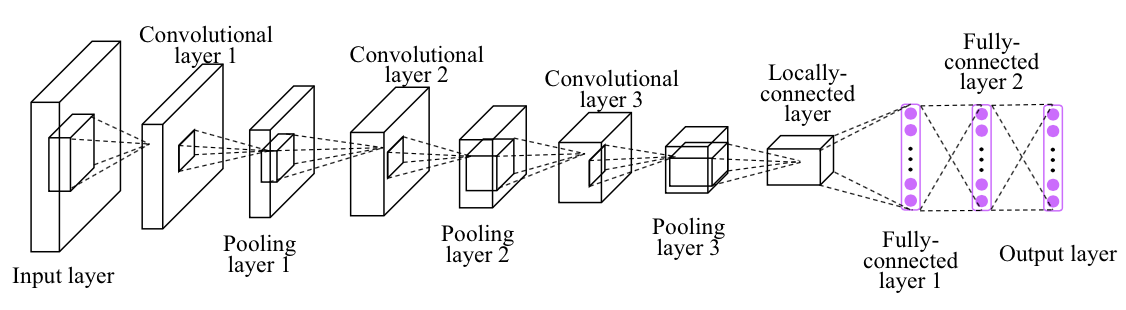


## Trucks vs cars using a fully-connected neural network classifier

In [17]:
# We create a truck_vs_car dataset from Cifar10
class_names = ['truck', 'car']

idx_trucks = np.argwhere(train_labels[:,0] == 9)
idx_cars = np.argwhere(train_labels[:,0] == 1)

train_size = 5000

train_images_trucks_cars = np.zeros((train_size,32,32,3), dtype='uint8')
train_labels_trucks_cars = np.zeros((train_size,1))

train_images_trucks_cars[:train_size//2] = train_images[idx_trucks[:train_size//2,0]]
train_images_trucks_cars[train_size//2:train_size] = train_images[idx_cars[:train_size//2,0]]

train_labels_trucks_cars[:train_size//2] = tf.zeros_like(idx_trucks[:train_size//2])
train_labels_trucks_cars[train_size//2:train_size] = tf.ones_like(idx_cats[:train_size//2])

train_images_trucks_cars = tf.convert_to_tensor(train_images_trucks_cars)

indices = tf.range(start=0, limit=tf.shape(train_images_trucks_cars)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

train_images_trucks_cars = tf.gather(train_images_trucks_cars, shuffled_indices)
train_labels_trucks_cars = tf.gather(train_labels_trucks_cars, shuffled_indices)



In [18]:
idt_trucks = np.argwhere(test_labels[:,0] == 9)
idt_cars = np.argwhere(test_labels[:,0] == 1)

test_size = 1000

test_images_trucks_cars = np.zeros((test_size,32,32,3), dtype='uint8')
test_labels_trucks_cars = np.zeros((test_size,1))

test_images_trucks_cars[:test_size//2] = test_images[idt_trucks[:test_size//2,0]]
test_images_trucks_cars[test_size//2:test_size] = test_images[idt_cars[:test_size//2,0]]

test_labels_trucks_cars[:test_size//2] = tf.zeros_like(idt_trucks[:test_size//2])
test_labels_trucks_cars[test_size//2:test_size] = tf.ones_like(idt_cars[:test_size//2])

test_images_trucks_cars = tf.convert_to_tensor(test_images_trucks_cars)

indices = tf.range(start=0, limit=tf.shape(test_images_trucks_cars)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)

test_images_trucks_cars = tf.gather(test_images_trucks_cars, shuffled_indices)
test_labels_trucks_cars = tf.gather(test_labels_trucks_cars, shuffled_indices)

# We can check the dimensions of the new dataset
print(train_images_trucks_cars.shape)
print(test_images_trucks_cars.shape)

(5000, 32, 32, 3)
(1000, 32, 32, 3)


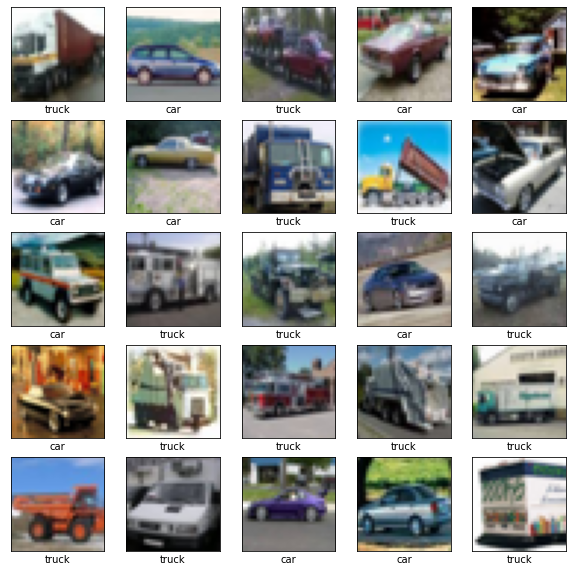

In [19]:
# Plot some pictures
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_trucks_cars[i])
    plt.xlabel(class_names[train_labels_trucks_cars[i][0]])
plt.show()

In [20]:
# Preprocess the data: Normalize pixel values to be between 0 and 1
train_images_trucks_cars = train_images_trucks_cars / 255
test_images_trucks_cars = test_images_trucks_cars / 255

# Fully-connected neural network
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images_trucks_cars, train_labels_trucks_cars, 
                    epochs=20, 
                    validation_data=(test_images_trucks_cars, test_labels_trucks_cars))


Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 1s 251us/sample - loss: 0.7022 - accuracy: 0.6234 - val_loss: 0.5771 - val_accuracy: 0.7210
Epoch 2/20
5000/5000 [==============================] - 1s 131us/sample - loss: 0.6086 - accuracy: 0.6672 - val_loss: 0.5988 - val_accuracy: 0.6800
Epoch 3/20
5000/5000 [==============================] - 1s 132us/sample - loss: 0.5943 - accuracy: 0.6820 - val_loss: 0.5555 - val_accuracy: 0.7390
Epoch 4/20
5000/5000 [==============================] - 1s 129us/sample - loss: 0.5856 - accuracy: 0.6906 - val_loss: 0.5495 - val_accuracy: 0.7400
Epoch 5/20
5000/5000 [==============================] - 1s 128us/sample - loss: 0.5805 - accuracy: 0.6964 - val_loss: 0.5838 - val_accuracy: 0.6910
Epoch 6/20
5000/5000 [==============================] - 1s 127us/sample - loss: 0.5729 - accuracy: 0.7060 - val_loss: 0.5616 - val_accuracy: 0.7180
Epoch 7/20
5000/5000 [==============================] - 1s 128us

1000/1 - 0s - loss: 0.6810 - accuracy: 0.4670
test loss: 0.8996170749664306
test accuracy: 0.467


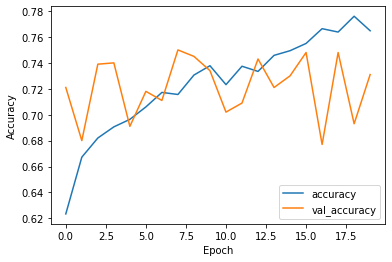

In [21]:
# Evaluate the model

plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images_cats_dogs,  test_labels_cats_dogs, verbose=2)

print('test loss:', test_loss)
print('test accuracy:', test_acc)

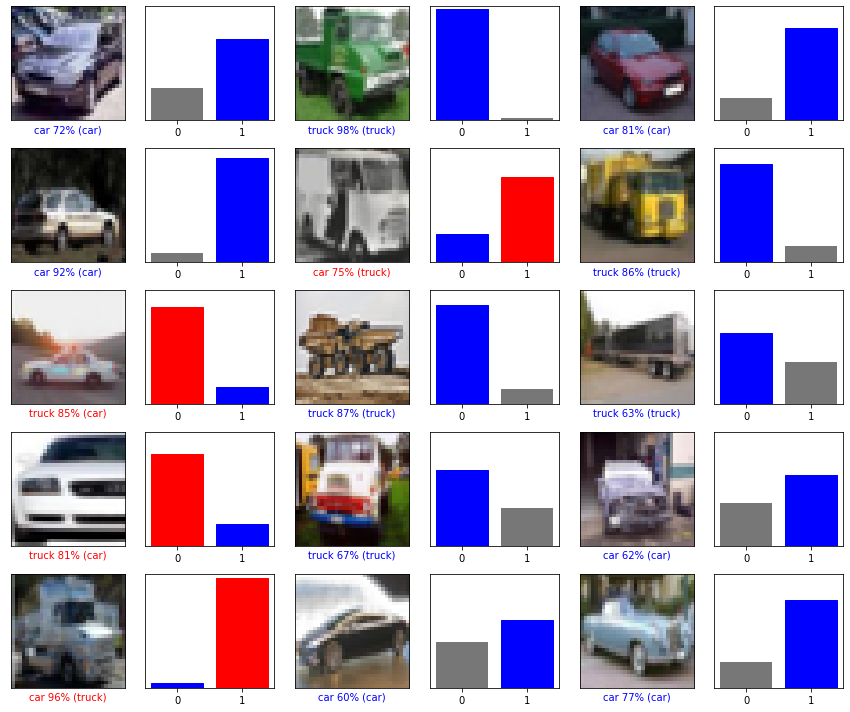

In [22]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images_trucks_cars)

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels_trucks_cars, test_images_trucks_cars)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels_trucks_cars)
plt.tight_layout()
plt.show()

## Trucks vs cars using a convoluted neural network classifier

In [23]:
#Convolutional neural networks
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(2))


model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images_trucks_cars, train_labels_trucks_cars, 
                    epochs=20, 
                    validation_data=(test_images_trucks_cars, test_labels_trucks_cars))


Train on 5000 samples, validate on 1000 samples
Epoch 1/20
5000/5000 [==============================] - 4s 705us/sample - loss: 0.6054 - accuracy: 0.6726 - val_loss: 0.5782 - val_accuracy: 0.7010
Epoch 2/20
5000/5000 [==============================] - 3s 534us/sample - loss: 0.4914 - accuracy: 0.7604 - val_loss: 0.4538 - val_accuracy: 0.7910
Epoch 3/20
5000/5000 [==============================] - 3s 535us/sample - loss: 0.4203 - accuracy: 0.8094 - val_loss: 0.3492 - val_accuracy: 0.8470
Epoch 4/20
5000/5000 [==============================] - 3s 552us/sample - loss: 0.3753 - accuracy: 0.8338 - val_loss: 0.3649 - val_accuracy: 0.8420
Epoch 5/20
5000/5000 [==============================] - 3s 581us/sample - loss: 0.3178 - accuracy: 0.8648 - val_loss: 0.3184 - val_accuracy: 0.8620
Epoch 6/20
5000/5000 [==============================] - 3s 600us/sample - loss: 0.2845 - accuracy: 0.8788 - val_loss: 0.2972 - val_accuracy: 0.8750
Epoch 7/20
5000/5000 [==============================] - 3s 589us

1000/1 - 0s - loss: 1.8904 - accuracy: 0.4880
test loss: 2.9647979249954224
test accuracy: 0.488


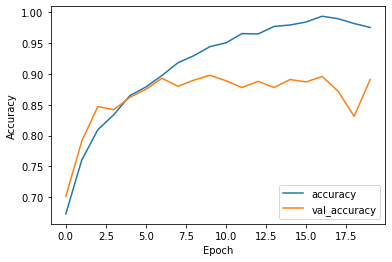

In [25]:
# Evaluate the model

plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images_cats_dogs,  test_labels_cats_dogs, verbose=2)

print('test loss:', test_loss)
print('test accuracy:', test_acc)

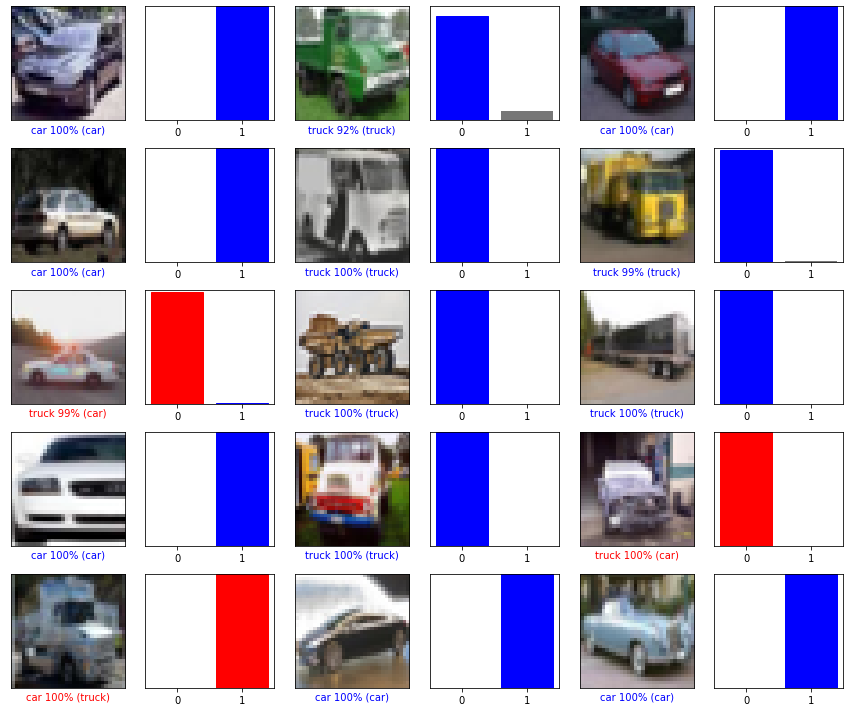

In [26]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images_trucks_cars)

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels_trucks_cars, test_images_trucks_cars)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels_trucks_cars)
plt.tight_layout()
plt.show()

## Global convoluted neural network

In [35]:
# Reduce the train size if you have kernel problems
train_size = 10000
np.random.seed(42)
random_ind = np.random.randint(train_images.shape[0], size=train_size)

train_images_subset = train_images[random_ind,:]
train_labels_subset = train_labels[random_ind,:]

train_images = tf.convert_to_tensor(train_images_subset)
train_labels = tf.convert_to_tensor(train_labels_subset)

test_size = 2000
random_ind = np.random.randint(test_images.shape[0], size=test_size)

test_images_subset = test_images[random_ind,:]
test_labels_subset = test_labels[random_ind,:]

test_images = tf.convert_to_tensor(test_images_subset)
test_labels = tf.convert_to_tensor(test_labels_subset)


# We can check the dimensions of the new dataset
print(train_images.shape)
print(test_images.shape)


(10000, 32, 32, 3)
(2000, 32, 32, 3)


In [36]:
#Convolutional neural networks
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(10))


model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)               

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, 
                    epochs=20, 
                    validation_data=(test_images, test_labels))

Train on 10000 samples, validate on 2000 samples
Epoch 1/20
10000/10000 [==============================] - 6s 641us/sample - loss: 2.5587 - accuracy: 0.2459 - val_loss: 1.8956 - val_accuracy: 0.2940
Epoch 2/20
10000/10000 [==============================] - 6s 559us/sample - loss: 1.7522 - accuracy: 0.3647 - val_loss: 1.7220 - val_accuracy: 0.3600
Epoch 3/20
10000/10000 [==============================] - 6s 614us/sample - loss: 1.5896 - accuracy: 0.4256 - val_loss: 1.6261 - val_accuracy: 0.4155
Epoch 4/20
10000/10000 [==============================] - 6s 628us/sample - loss: 1.4442 - accuracy: 0.4830 - val_loss: 1.6897 - val_accuracy: 0.3935
Epoch 5/20
10000/10000 [==============================] - 6s 628us/sample - loss: 1.3191 - accuracy: 0.5202 - val_loss: 1.5725 - val_accuracy: 0.4485
Epoch 6/20
10000/10000 [==============================] - 6s 637us/sample - loss: 1.1980 - accuracy: 0.5770 - val_loss: 1.4770 - val_accuracy: 0.4765
Epoch 7/20
10000/10000 [===========================

2000/1 - 1s - loss: 3.4413 - accuracy: 0.4600
test loss: 3.3018643417358398
test accuracy: 0.46


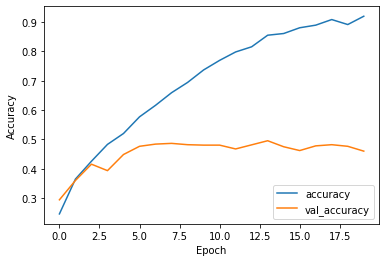

In [38]:
# Evaluate the model
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('test loss:', test_loss)
print('test accuracy:', test_acc)


In [39]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_images)

def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i][0], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i][0]
  plt.grid(False)
  plt.xticks(range(len(class_names)))
  plt.yticks([])
  thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


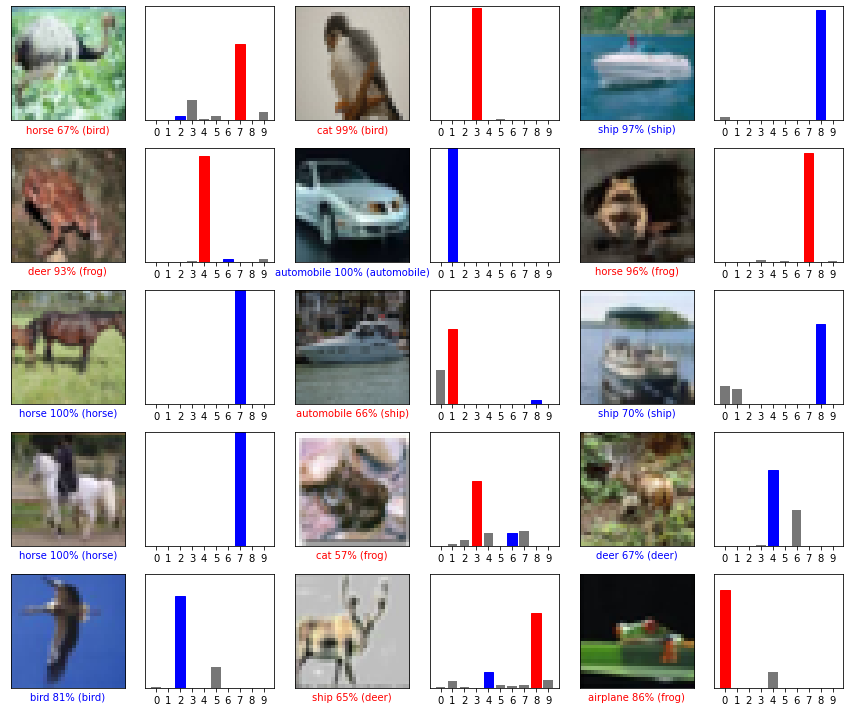

In [40]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()